In [61]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [62]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Netflix Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [63]:
# Get datasets from github repository
!wget https://raw.githubusercontent.com/danielhwei/Financial-Data/master/netflix1%20net%20income%20quarterly.csv

--2020-08-01 15:39:21--  https://raw.githubusercontent.com/danielhwei/Financial-Data/master/netflix1%20net%20income%20quarterly.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.64.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 696 [text/plain]
Saving to: ‘netflix1 net income quarterly.csv.2’

netflix1 net income 100%[===================>]     696  --.-KB/s    in 0s      

2020-08-01 15:39:21 (25.5 MB/s) - ‘netflix1 net income quarterly.csv.2’ saved [696/696]



In [64]:
netincome = pd.read_csv('/Users/danielwei/Desktop/RCompSci/Financial Data/netflix1 net income quarterly.csv', index_col=['Time'], parse_dates=['Time'])

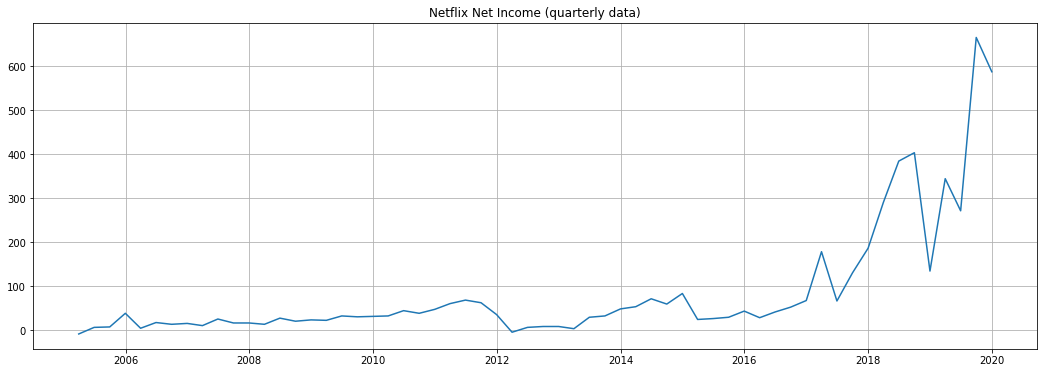

In [65]:
plt.figure(figsize=(18, 6))
plt.plot(netincome.NetIncome)
plt.title('Netflix Net Income (quarterly data)')
plt.grid(True)
plt.show()

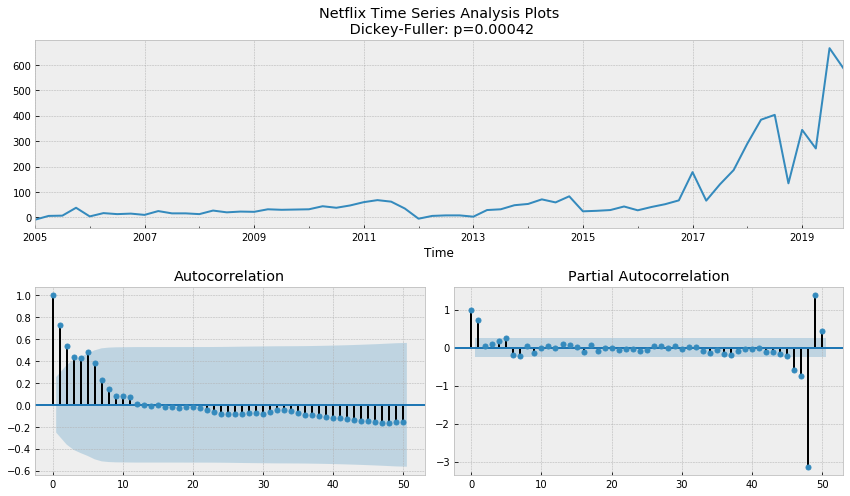

In [66]:
tsplot(netincome.NetIncome, lags=50)

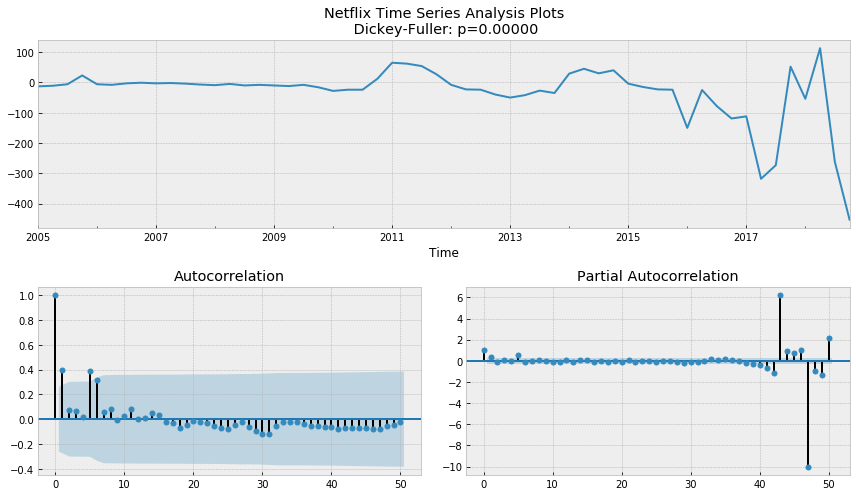

In [67]:
# The seasonal difference
netincome_diff = netincome.NetIncome - netincome.NetIncome.shift(4)
tsplot(netincome_diff[4:], lags=50)

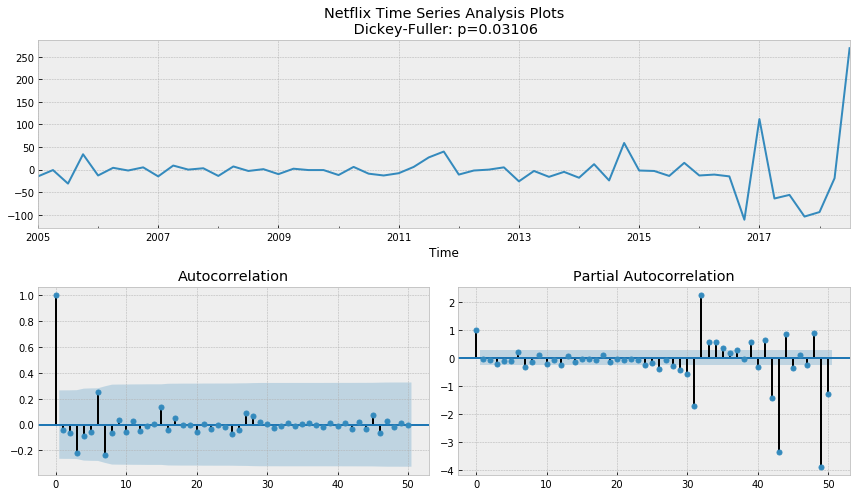

In [68]:
netincome_diff = netincome.NetIncome - netincome.NetIncome.shift(1)
tsplot(netincome_diff[4+1:], lags=50)

In [69]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 4 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [70]:
def optimizeSARIMA(y, parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [71]:
%%time
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(netincome.NetIncome, parameters_list, d, D, s)


CPU times: user 6.24 s, sys: 70.4 ms, total: 6.31 s
Wall time: 6.32 s


In [72]:
result_table.head()

,parameters,aic
0,"(4, 2, 0, 1)",606.954795
1,"(3, 2, 1, 0)",608.674162
2,"(4, 3, 0, 1)",613.102352
3,"(3, 3, 1, 0)",614.604117
4,"(4, 3, 0, 0)",615.751936


In [73]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(netincome.NetIncome, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           NetIncome   No. Observations:                   60
Model:             SARIMAX(4, 1, 2)x(0, 1, [1], 4)   Log Likelihood                -295.477
Date:                             Sat, 01 Aug 2020   AIC                            606.955
Time:                                     15:39:41   BIC                            623.013
Sample:                                          0   HQIC                           613.165
                                              - 60                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4828      0.188     -2.563      0.010      -0.852      -0.114
ar.L2         -0.6516      

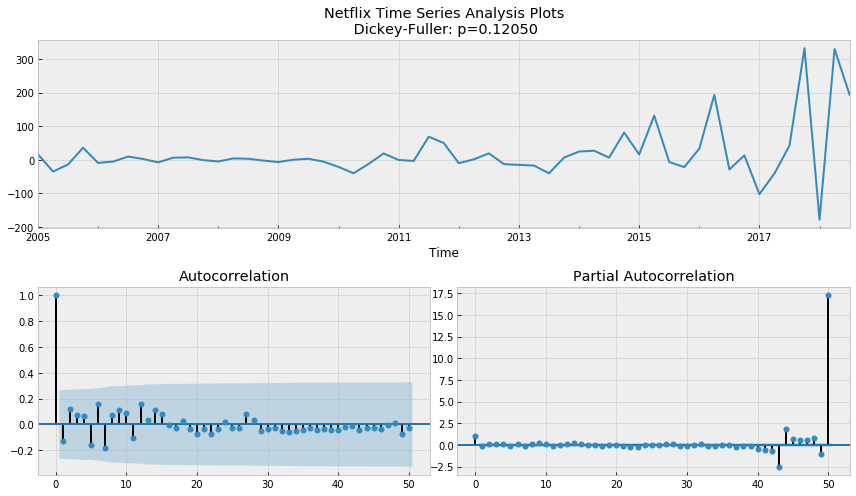

In [74]:
tsplot(best_model.resid[4+1:], lags=50)

In [75]:
def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

TypeError: float() argument must be a string or a number, not 'Timestamp'

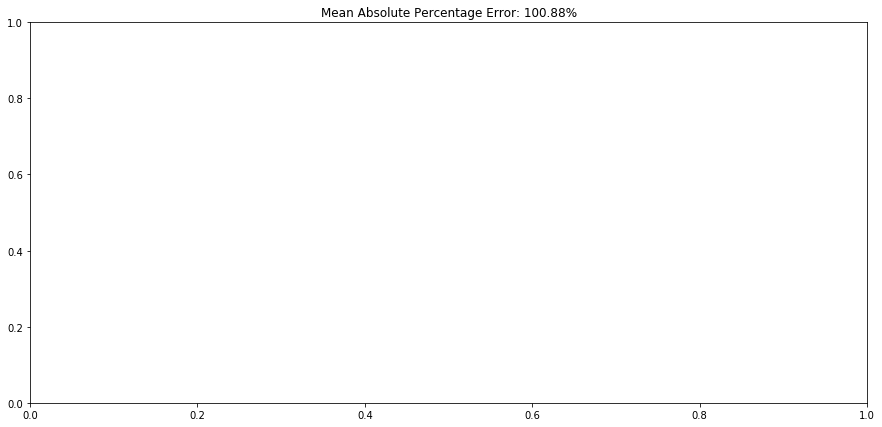

In [77]:
plotSARIMA(netincome, best_model, 50)